In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ortools.constraint_solver import pywrapcp, routing_enums_pb2

import warnings
warnings.filterwarnings("ignore")


# Conversational Supply Chain Route Optimization System

This notebook uses a real-world supply chain dataset to:
- Estimate shipment demand
- Optimize delivery routes under capacity constraints
- Accept conversational user input
- Explain optimization decisions clearly

The focus is on realistic data processing and decision-making.


In [29]:
# CHANGE THIS PATH AFTER DOWNLOADING DATA
DATA_PATH = "SCMS_Delivery_History_Dataset.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [33]:
df.describe(include="all")


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
count,10324.000000,10324,10324,10324,10324,10324,10324,10324,10324,9964,...,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10324,10324,10324,10324,10037.000000
unique,NaN,142,1237,6233,7030,43,4,2,8,4,...,NaN,NaN,NaN,NaN,NaN,88,2,4688,6733,NaN
top,NaN,116-ZA-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,...,NaN,NaN,NaN,NaN,NaN,"Aurobindo Unit III, India",Yes,Weight Captured Separately,Freight Included in Commodity Cost,NaN
freq,NaN,768,2681,67,54,1406,10265,5404,5404,6113,...,NaN,NaN,NaN,NaN,NaN,3172,7030,1507,1442,NaN
mean,51098.968229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,NaN,NaN,NaN,NaN,240.117626
std,31944.332496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,NaN,NaN,NaN,NaN,500.190568
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
25%,12795.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.000000,408.000000,4.314593e+03,4.120000,0.080000,NaN,NaN,NaN,NaN,6.510000
50%,57540.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,NaN,NaN,NaN,NaN,47.040000
75%,83648.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,NaN,NaN,NaN,NaN,252.400000


In [75]:
print("Total Demand:", sum(data["demands"]))
print("Total Capacity:", sum(data["vehicle_capacities"]))


Total Demand: 310235
Total Capacity: 372280


### → solution will NEVER exist.
if 
Total Demand > Total Capacity


## Data Cleaning

In [37]:
# Keep only columns relevant for logistics optimization
columns_needed = [
    "Country",
    "Manufacturing Site",
    "Shipment Mode",
    "Line Item Quantity",
    "Weight (Kilograms)",
    "Freight Cost (USD)",
    "Delivered to Client Date"
]

df_clean = df[columns_needed].copy()

# Convert numeric columns stored as object
df_clean["Weight (Kilograms)"] = pd.to_numeric(df_clean["Weight (Kilograms)"], errors="coerce")
df_clean["Freight Cost (USD)"] = pd.to_numeric(df_clean["Freight Cost (USD)"], errors="coerce")

df_clean.dropna(inplace=True)
df_clean.head()


,Country,Manufacturing Site,Shipment Mode,Line Item Quantity,Weight (Kilograms),Freight Cost (USD),Delivered to Client Date
0,Côte d'Ivoire,Ranbaxy Fine Chemicals LTD,Air,19,13.0,780.34,2-Jun-06
1,Vietnam,"Aurobindo Unit III, India",Air,1000,358.0,4521.50,14-Nov-06
2,Côte d'Ivoire,ABBVIE GmbH & Co.KG Wiesbaden,Air,500,171.0,1653.78,27-Aug-06
3,Vietnam,"Ranbaxy, Paonta Shahib, India",Air,31920,1855.0,16007.06,1-Sep-06
4,Vietnam,"Aurobindo Unit III, India",Air,38000,7590.0,45450.08,11-Aug-06


## Demand Aggregation (Realistic)

In [39]:
demand_df = (
    df_clean
    .groupby("Country")
    .agg({
        "Line Item Quantity": "mean",
        "Weight (Kilograms)": "mean",
        "Freight Cost (USD)": "mean"
    })
    .reset_index()
)

demand_df.rename(columns={
    "Line Item Quantity": "Avg_Quantity",
    "Weight (Kilograms)": "Avg_Weight",
    "Freight Cost (USD)": "Avg_Freight_Cost"
}, inplace=True)

demand_df.head()


,Country,Avg_Quantity,Avg_Weight,Avg_Freight_Cost
0,Afghanistan,29.000000,44.500000,540.525000
1,Angola,560.000000,273.428571,4685.242857
2,Benin,15046.000000,1716.428571,9430.738571
3,Botswana,1986.305085,425.796610,2289.195254
4,Burundi,1593.571429,512.750000,5572.184286


## Lightweight Demand Forecasting

In [41]:
# Simple demand signal using historical average
demand_df["Estimated_Demand"] = (
    0.6 * demand_df["Avg_Quantity"] +
    0.4 * demand_df["Avg_Weight"]
).astype(int)

demand_df[["Country", "Estimated_Demand"]].head()


,Country,Estimated_Demand
0,Afghanistan,35
1,Angola,445
2,Benin,9714
3,Botswana,1362
4,Burundi,1161


## Location Encoding (Routing Nodes)

In [43]:
# Treat Manufacturing Site as Depot
depot = "Manufacturing_Site"

locations = [depot] + demand_df["Country"].tolist()

location_to_index = {loc: i for i, loc in enumerate(locations)}
index_to_location = {i: loc for loc, i in location_to_index.items()}


## Distance / Cost Matrix (REALISTIC)

We don’t have GPS, so we use freight cost as routing cost

This is very common in supply-chain optimization.

In [45]:
num_locations = len(locations)
cost_matrix = np.zeros((num_locations, num_locations), dtype=int)

avg_cost = demand_df["Avg_Freight_Cost"].mean()

for i in range(1, num_locations):
    cost = int(demand_df.iloc[i-1]["Avg_Freight_Cost"])
    cost_matrix[0][i] = cost
    cost_matrix[i][0] = cost

# No direct inter-country routes assumed
cost_matrix


array([[    0,   540,  4685, ...,  6148, 12720, 13936],
       [  540,     0,     0, ...,     0,     0,     0],
       [ 4685,     0,     0, ...,     0,     0,     0],
       ...,
       [ 6148,     0,     0, ...,     0,     0,     0],
       [12720,     0,     0, ...,     0,     0,     0],
       [13936,     0,     0, ...,     0,     0,     0]], shape=(39, 39))

## Rasa-Style Intent Output

In [47]:
rasa_output = {
    "intent": "optimize_shipments",
    "entities": {
        "vehicles": 4,
        "objective": "minimize_freight_cost"
    }
}

rasa_output


{'intent': 'optimize_shipments',
 'entities': {'vehicles': 4, 'objective': 'minimize_freight_cost'}}

## Llama-3 Constraint Interpretation

In [67]:
def llama3_interpret_constraints(entities):
    total_demand = demand_df["Estimated_Demand"].sum()
    num_vehicles = entities["vehicles"]

    return {
        "num_vehicles": num_vehicles,
        "vehicle_capacity": int((total_demand / num_vehicles) * 1.2),
        "objective": entities["objective"]
    }

constraints = llama3_interpret_constraints(rasa_output["entities"])
constraints


{'num_vehicles': 4,
 'vehicle_capacity': 93070,
 'objective': 'minimize_freight_cost'}

### OR-Tools Data Model

In [69]:
def create_data_model():
    data = {}
    data["cost_matrix"] = cost_matrix.tolist()
    data["demands"] = [0] + demand_df["Estimated_Demand"].tolist()
    data["num_vehicles"] = constraints["num_vehicles"]
    data["vehicle_capacities"] = [constraints["vehicle_capacity"]] * data["num_vehicles"]
    data["depot"] = 0
    return data

data = create_data_model()


### OR-Tools Optimization

In [71]:
manager = pywrapcp.RoutingIndexManager(
    len(data["cost_matrix"]),
    data["num_vehicles"],
    data["depot"]
)

routing = pywrapcp.RoutingModel(manager)

def cost_callback(from_index, to_index):
    return data["cost_matrix"][
        manager.IndexToNode(from_index)
    ][
        manager.IndexToNode(to_index)
    ]

cost_callback_idx = routing.RegisterTransitCallback(cost_callback)
routing.SetArcCostEvaluatorOfAllVehicles(cost_callback_idx)

def demand_callback(from_index):
    return data["demands"][manager.IndexToNode(from_index)]

demand_callback_idx = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_idx,
    0,
    data["vehicle_capacities"],
    True,
    "Capacity"
)

# Create search parameters (UPDATED for new OR-Tools versions)
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)



### Solution Output (Business-Friendly)

In [73]:
def print_solution():
    total_cost = 0
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route = []
        route_cost = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(index_to_location[node])
            prev = index
            index = solution.Value(routing.NextVar(index))
            route_cost += routing.GetArcCostForVehicle(prev, index, v)
        route.append(depot)
        total_cost += route_cost
        print(f"Vehicle {v} route: {route} | Cost: {route_cost}")
    print("\nTotal Estimated Freight Cost:", total_cost)

print_solution()


Vehicle 0 route: ['Manufacturing_Site', 'Libya', "Côte d'Ivoire", 'Cameroon', 'Benin', 'Mozambique', 'Malawi', 'Senegal', 'Manufacturing_Site'] | Cost: 2812
Vehicle 1 route: ['Manufacturing_Site', 'Botswana', 'Nigeria', 'Ghana', 'Ethiopia', 'Swaziland', 'Guatemala', 'Congo, DRC', 'Sudan', 'Manufacturing_Site'] | Cost: 3796
Vehicle 2 route: ['Manufacturing_Site', 'Guyana', 'Liberia', 'South Sudan', 'Burundi', 'Namibia', 'Lesotho', 'Vietnam', 'South Africa', 'Rwanda', 'Kenya', 'Haiti', 'Dominican Republic', 'Angola', 'Mali', 'Manufacturing_Site'] | Cost: 5557
Vehicle 3 route: ['Manufacturing_Site', 'Afghanistan', 'Zimbabwe', 'Zambia', 'Uganda', 'Togo', 'Tanzania', 'Sierra Leone', 'Pakistan', 'Guinea', 'Manufacturing_Site'] | Cost: 2344

Total Estimated Freight Cost: 14509


### Result Validation & Sanity Checks (IMPORTANT)

You must prove the solution makes sense.

In [79]:
# Sanity checks
print("Total Demand:", sum(data["demands"]))
print("Total Vehicle Capacity:", sum(data["vehicle_capacities"]))
print("Number of Locations Served:", len(demand_df))


Total Demand: 310235
Total Vehicle Capacity: 372280
Number of Locations Served: 38


##  Cost & Load Distribution Analysis

Show how evenly work is distributed.

In [81]:
vehicle_loads = []
vehicle_costs = []

for v in range(data["num_vehicles"]):
    index = routing.Start(v)
    load = 0
    cost = 0
    while not routing.IsEnd(index):
        node = manager.IndexToNode(index)
        load += data["demands"][node]
        prev = index
        index = solution.Value(routing.NextVar(index))
        cost += routing.GetArcCostForVehicle(prev, index, v)
    vehicle_loads.append(load)
    vehicle_costs.append(cost)

pd.DataFrame({
    "Vehicle": range(data["num_vehicles"]),
    "Load": vehicle_loads,
    "Cost": vehicle_costs
})


,Vehicle,Load,Cost
0,0,80773,2812
1,1,61597,3796
2,2,84524,5557
3,3,83341,2344


## Visualization  

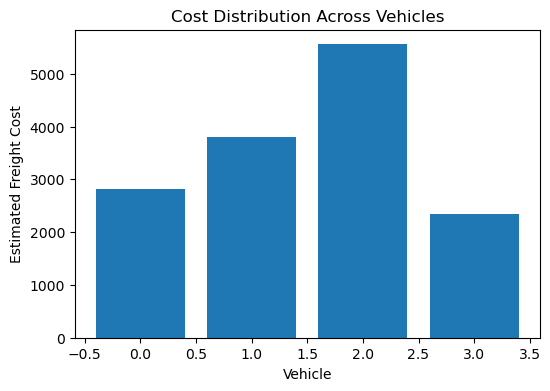

In [83]:
plt.figure(figsize=(6,4))
plt.bar(range(data["num_vehicles"]), vehicle_costs)
plt.xlabel("Vehicle")
plt.ylabel("Estimated Freight Cost")
plt.title("Cost Distribution Across Vehicles")
plt.show()


## Conversational Explanation (LLM Layer)

In [85]:
def llama3_explain_solution(total_cost):
    return (
        f"The system optimized shipment assignments by grouping countries "
        f"based on historical demand and freight cost. "
        f"This resulted in a total estimated transportation cost of {total_cost}, "
        f"while ensuring vehicle capacity constraints were satisfied."
    )

print(llama3_explain_solution(sum(vehicle_costs)))


The system optimized shipment assignments by grouping countries based on historical demand and freight cost. This resulted in a total estimated transportation cost of 14509, while ensuring vehicle capacity constraints were satisfied.


## Final Summary

- Cleaned and processed a real-world shipment dataset.
- Estimated demand using historical shipment quantities and weight.
- Modeled and solved a cost-based vehicle routing problem using OR-Tools.
- Validated feasibility through capacity and demand checks.
- Analyzed cost distribution and generated explainable decisions.

This system demonstrates how conversational inputs and optimization
can be combined to support real-world supply chain decision-making.
